In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(r'../data/merged_data/preprocessed_data.csv')

In [3]:
data['order_purchase_timestamp']

0         2017-10-02 10:56:33
1         2017-10-02 10:56:33
2         2017-10-02 10:56:33
3         2018-08-08 08:38:49
4         2017-11-18 19:28:06
                 ...         
112291    2018-02-06 12:58:58
112292    2017-08-27 14:46:43
112293    2018-01-08 21:28:27
112294    2018-01-08 21:28:27
112295    2018-03-08 20:57:30
Name: order_purchase_timestamp, Length: 112296, dtype: object

In [4]:
#converting the timestamp format data to date data as we need just the date and not the exact time
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'], errors='coerce').dt.date
data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date'], errors='coerce').dt.date
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'], errors='coerce').dt.date
data['shipping_limit_date'] = pd.to_datetime(data['shipping_limit_date'], errors='coerce').dt.date

type(data['order_delivered_customer_date'][0])

datetime.date

In [5]:
#subtracting the order_purchase_time to rest time based feature and converting date time into string to remove the timestamp notation 
data['delivery_days'] = data['order_delivered_customer_date'].sub(data['order_purchase_timestamp'],axis=0).astype(str)
data['estimated_days'] = data['order_estimated_delivery_date'].sub(data['order_purchase_timestamp'],axis=0).astype(str)
data['ships_in'] = data['shipping_limit_date'].sub(data['order_purchase_timestamp'],axis=0).astype(str)

In [6]:
data['delivery_days']

0          8 days, 0:00:00
1          8 days, 0:00:00
2          8 days, 0:00:00
3          9 days, 0:00:00
4         14 days, 0:00:00
                ...       
112291    22 days, 0:00:00
112292    25 days, 0:00:00
112293    17 days, 0:00:00
112294    17 days, 0:00:00
112295     8 days, 0:00:00
Name: delivery_days, Length: 112296, dtype: object

In [7]:
data['delivery_days'] = data['delivery_days'].str.split(',').str.get(0)
data['estimated_days'] = data['estimated_days'].str.split(',').str.get(0)
data['ships_in'] = data['ships_in'].str.split(',').str.get(0)

In [8]:
data['delivery_days'].head(10)

0     8 days
1     8 days
2     8 days
3     9 days
4    14 days
5     3 days
6    17 days
7    10 days
8    10 days
9    18 days
Name: delivery_days, dtype: object

In [9]:
#converting type to int
data['delivery_days'] = data['delivery_days'].str.extract(r'(\d+)').astype(float).astype(int)
data['estimated_days'] = data['estimated_days'].str.replace(" days","").astype(int)
data['ships_in'] = data['ships_in'].str.replace(" days","").astype(int)
data['arrival_time'] = (data['estimated_days'] - data['delivery_days']).apply(lambda x: 'Early/OnTime' if x > 0 else 'Late')

In [10]:
data['delivery_days']

0          8
1          8
2          8
3          9
4         14
          ..
112291    22
112292    25
112293    17
112294    17
112295     8
Name: delivery_days, Length: 112296, dtype: int32

C:\Users\adityajha01\.conda\envs\CustomerSatisfaction\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
C:\Users\adityajha01\.conda\envs\CustomerSatisfaction\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func

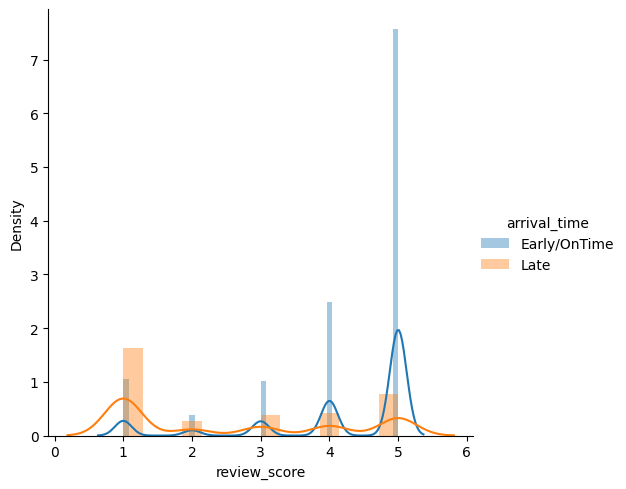

In [11]:
sns.FacetGrid(data, hue="arrival_time", height=5) \
   .map(sns.distplot, 'review_score') \
   .add_legend();
plt.show();

In [12]:
data.arrival_time.value_counts()

arrival_time
Early/OnTime    103630
Late              8666
Name: count, dtype: int64

**Observations**

1. Clearly from the above plot the cutomers are more likely to give an 4-5 rating if the product either arrives early or arrive on time.
2. As delivery time impacts a lot to the customer rating we will do further analysis on the delivery time.

In [13]:
#dropping exceptional delivery or possible outliers
ix = data[(data['delivery_days'] > 60) | (data['estimated_days'] > 60) | (data['ships_in'] > 60)].index
print(ix.shape)

print('Percentage of extermely late delivered packages in the dataset is: {}%'.format(round((((ix.shape[0])/(data.shape[0])))*100,3)))
#we can remove those outliers
data.drop(ix,inplace=True)

(606,)
Percentage of extermely late delivered packages in the dataset is: 0.54%


In [14]:
#binning and grouping delivery times into groups or classes

delivery_feedbacks = []
estimated_del_feedbacks = []
shipping_feedback = []
d_days = data.delivery_days.values.tolist()
est_days = data.estimated_days.values.tolist()
ship_days = data.ships_in.values.tolist()

#actual delivery days
for i in d_days:
    if i in range(0,8):
        delivery_feedbacks.append('Very_Fast')
    elif i in range(8,16):
        delivery_feedbacks.append('Fast')
    elif i in range(16,25):
        delivery_feedbacks.append('Neutral')
    elif i in range(25,40):
        delivery_feedbacks.append('Slow')
    elif i in range(40,61):
        delivery_feedbacks.append('Worst')

#estimated delivery days
for i in est_days:
    if i in range(0,8):
        estimated_del_feedbacks.append('Very_Fast')
    elif i in range(8,16):
        estimated_del_feedbacks.append('Fast')
    elif i in range(16,25):
        estimated_del_feedbacks.append('Neutral')
    elif i in range(25,40):
        estimated_del_feedbacks.append('Slow')
    elif i in range(40,61):
        estimated_del_feedbacks.append('Worst')

#estimated shipping days
for i in ship_days:
    if i in range(0,4):
        shipping_feedback.append('Very_Fast')
    elif i in range(4,8):
        shipping_feedback.append('Fast')
    elif i in range(8,16):
        shipping_feedback.append('Neutral')
    elif i in range(16,28):
        shipping_feedback.append('Slow')
    elif i in range(28,61):
        shipping_feedback.append('Worst')

#putting list values into the dataframe as feature
data['delivery_impression'] = delivery_feedbacks
data['estimated_del_impression'] = estimated_del_feedbacks
data['ship_impression'] = shipping_feedback

<Axes: ylabel='review_score'>

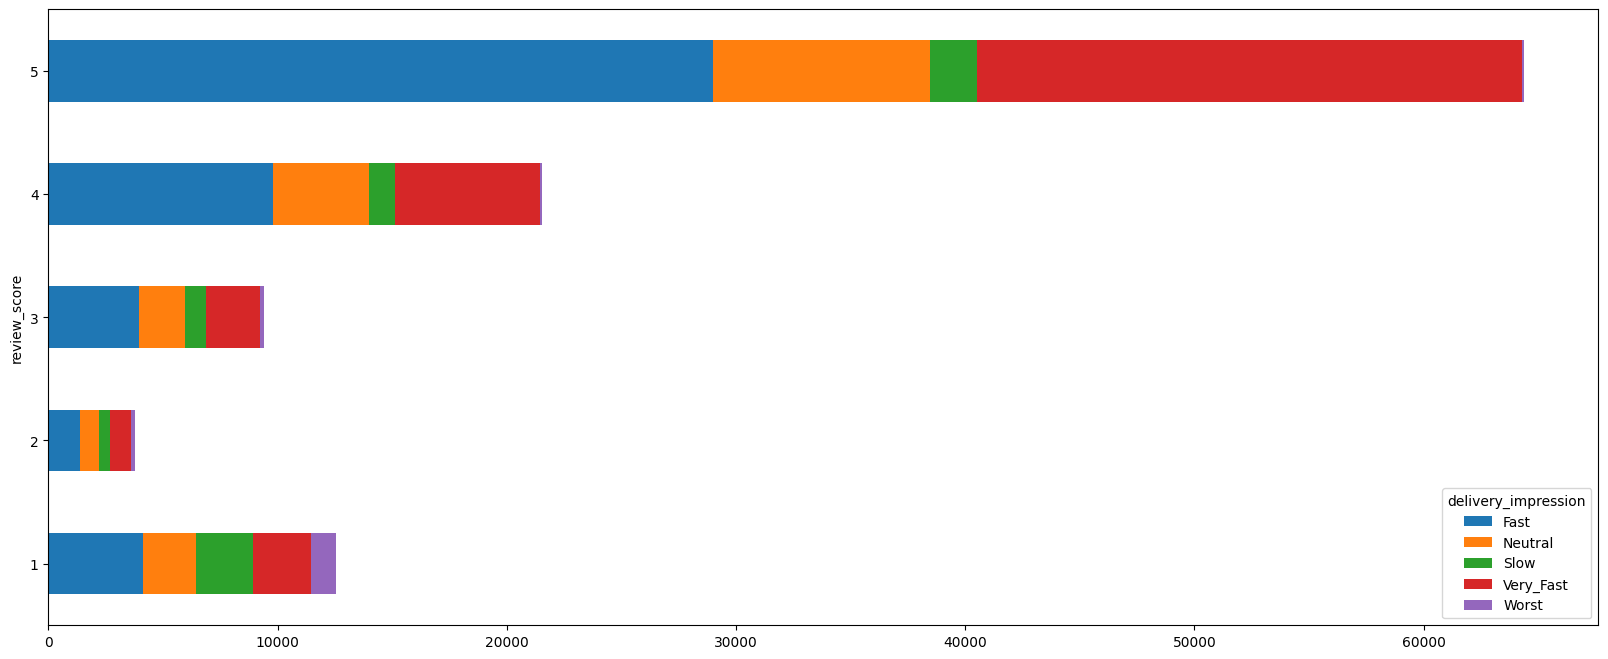

In [15]:
#Delivery Days histogram with review rating as hue
df_plot = data.groupby(['delivery_impression', 'review_score']).size().reset_index().pivot(columns='delivery_impression', index='review_score', values=0)
df_plot.plot(kind='barh',stacked=True,figsize=(20,8))

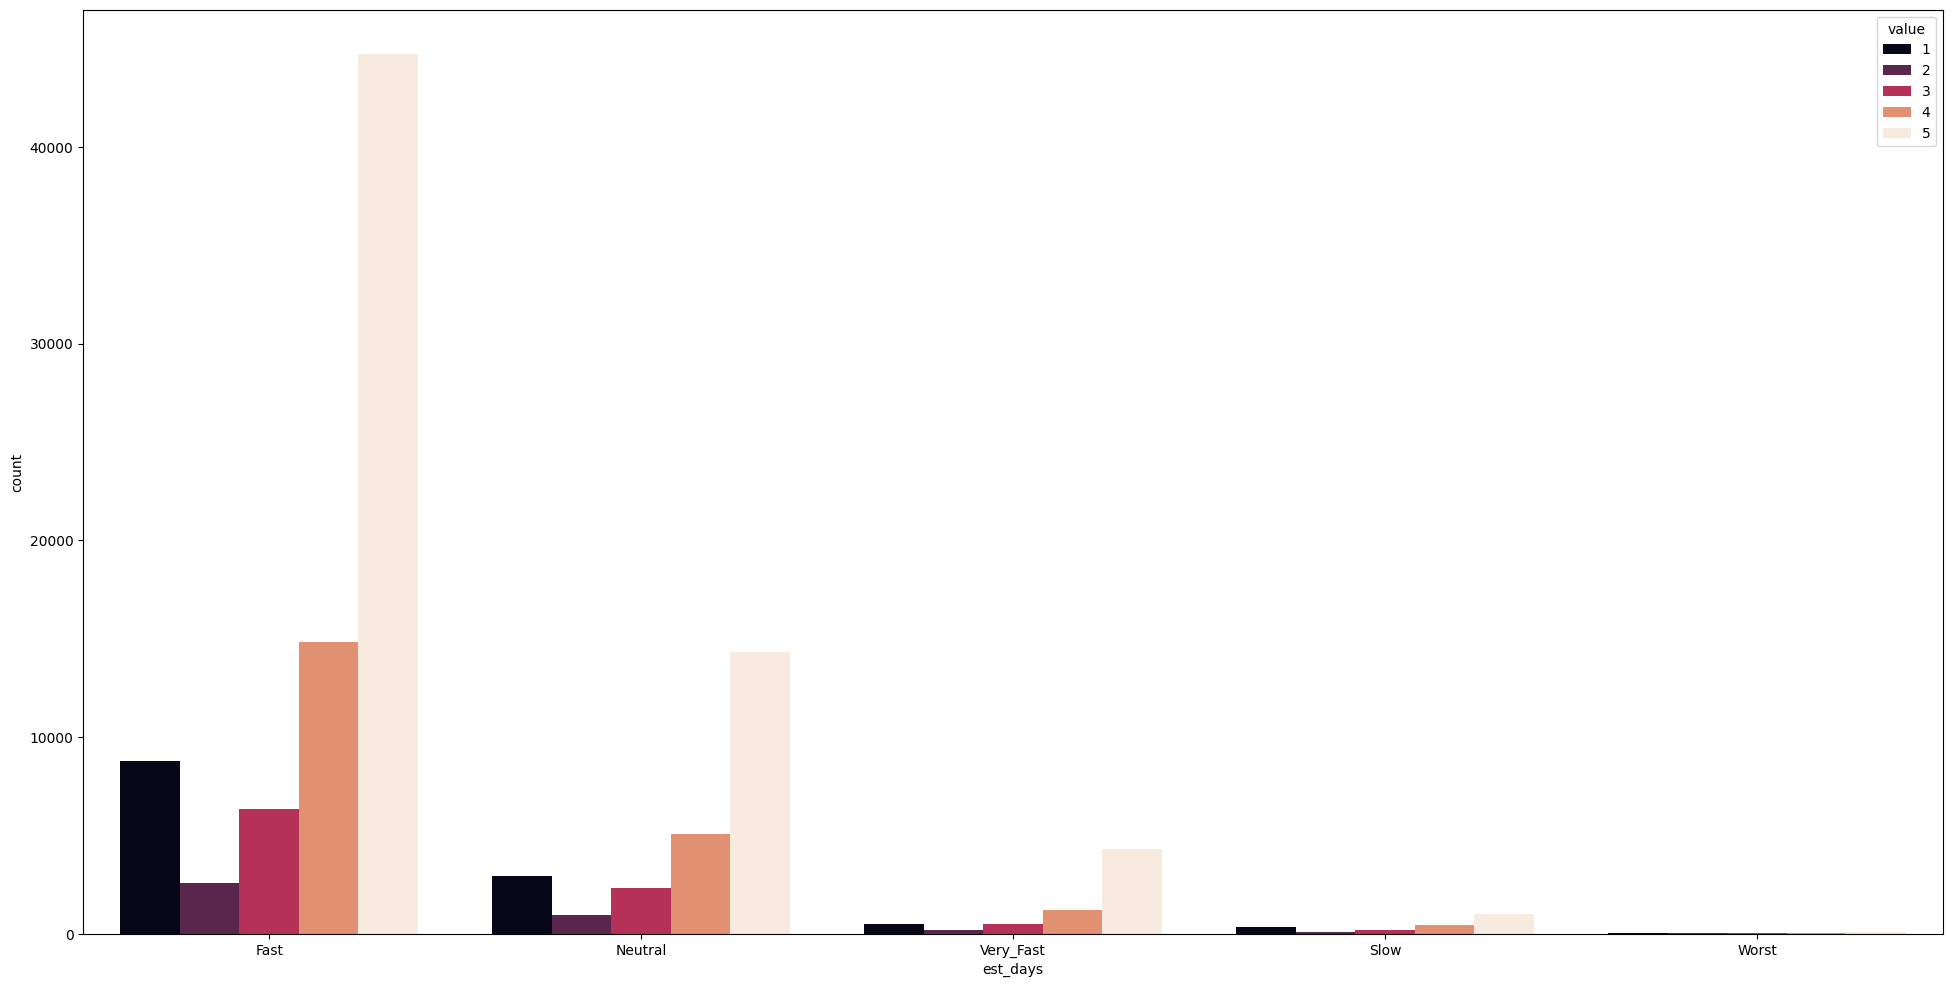

In [16]:
#Estimated Days histogram with review rating as hue
est_days = data.ship_impression.values.tolist()
review_score = data.review_score.values

# Create a DataFrame from the data
df = pd.DataFrame({'est_days': est_days, 'review_score': review_score})
melted_df = pd.melt(df, id_vars=['est_days'], value_vars=['review_score'])

# Plotting the histogram with 'est_days' as x-axis and 'review_score' as hue
fig = plt.figure(figsize=(24, 12))
sns.countplot(data=melted_df, x='est_days', hue='value', palette='rocket')
plt.show()

**Observations**

1. Majority of orders are delivered in the Fast range i.e (8-15) within 2 weeks .
2. However, next to it Very Fast range of delivery days which is (0-7) days.
3. Important observation here is customers are more likely to get things delivered in top 3 categories which are Fast,Very Fast and Neutral. From which majority of elment have rated the product to be 5 , some 4 while very few have rated less than in each of the 3 cases.
4. Delivery days is thus an important feature which can be added.
5. Moreover we have another feature which is estmated delivery date, so we also add a new feature to the dataset which is estimated delivery days. This can be some what useful, because this date is shown in advance to the user.
6. In the estimated delivery date feature, company have the maximum days it can take to reach.
7. Upon observing the histograms for the estimated_day with rating as hue, similar trend of maximum rating for all the Fast Neutral and slow category. However, very fast category becomes one of the least.

In [17]:
from collections import Counter
#finding all those customers who have made multiple product purchases
order_counts = [k for k,v in Counter(data.customer_unique_id).items() if v > 1]
existing_cust = []
for i in data.customer_unique_id.values:
    if i in order_counts:
        existing_cust.append(1)
    else:
        existing_cust.append(0)
len(existing_cust)

111690

In [18]:
print('Number of orders that are made using exisiting customer/Multiple orders are ',existing_cust.count(1))

Number of orders that are made using exisiting customer/Multiple orders are  34935


In [19]:
#seller popularity based on number of orders for each seller
max_value_count = data.seller_id.value_counts().max()
seller = data.seller_id.value_counts().to_dict()
seller_popularity = []
for _id in data.seller_id.values:
    seller_popularity.append(seller[_id])
data['seller_popularity'] = seller_popularity
data.shape

(111690, 32)

**Observations**

As in most of the cases customer and seller zip_code are not matching so we are dropping the feature because it will increase dimension by 34k.

In [20]:
#dropping all id based features
data.drop(['customer_unique_id','seller_id','product_id','zipCode_prefix_seller','zipCode_prefix_cust'],axis=1,inplace=True)

#adding exisitng customer and seller_ID feature

data['existing_cust'] = existing_cust
data.shape

(111690, 28)

In [21]:
#if score> 3, set score = 1
#if score<=3, set score = 0 
data.loc[data['review_score'] < 3 ,'Score'] = 0
data.loc[data['review_score'] > 3,'Score'] = 1
#removing neutral reviews
data.drop(data[data['review_score'] == 3].index,inplace=True)
data.drop('review_score',axis=1,inplace=True)
print(data.shape)

(102302, 28)


In [22]:
#removing the datetime features as we dont need them now
data.drop(['order_purchase_timestamp', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date','shipping_limit_date'],axis=1,inplace=True)
data.to_csv('../data/final_data.csv',index=False)

In [23]:
print(data.shape)
print('Final set of features are : ')
data.columns

(102302, 23)
Final set of features are : 


Index(['payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_city', 'customer_state', 'price',
       'freight_value', 'product_name_length', 'product_description_length',
       'product_photos_qty', 'seller_state', 'product_category_name',
       'delivery_days', 'estimated_days', 'ships_in', 'arrival_time',
       'delivery_impression', 'estimated_del_impression', 'ship_impression',
       'seller_popularity', 'existing_cust', 'Score'],
      dtype='object')

**Summary**

1. Data is heavily imbalanced having mostly positive review_score, which can impact the model so we have to perform data modelling accordingly.
2. From above analysis it is quite conclusive that the review_score highly depends on the delivery time, however some of the rest features are also useful but we need actual model to determine feature importances.
3. We have added few more features to the dataset that coresponds to the delivery and shipment.
4. We will be strict about sentiments in this analysis and consider even neutral or (3 rating) to be negetive because for product recommendation the stricter the benchmark, the better the results.
5. Feature engineering done here might not be sufficient to obtain the best accuracy so we might need to perform some more feature engineering.